# Resampling

# Methods and Imports

In [82]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from quasinet.qnet import load_qnet
from quasinet.qsampling import qsample

from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime
from IPython.display import display, HTML
import glob
from zedstat import zedstat

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
import optuna

from sklearn.impute import SimpleImputer


# optuna.logging.set_verbosity(optuna.logging.WARNING)

In [87]:
def _classification(diss, groups, output_path, name, retrains, n_trials, question_iter, classifier=RandomForestClassifier(n_jobs=-1), plot=False,):

    auc_dfs = list()
    # for each dissonance file
    for d in tqdm(diss, desc="Dissonance files"):
        # repeat performance calc
        for _ in tqdm(range(retrains), desc="Training cycles this file"):
            fig, ax = plt.subplots()
            aucs = list()
            z_aucs = list()
            z_aucs_lb = list()
            z_aucs_ub = list()
            roc_dfs = list()

            # which computes the auc for classifier at each question marker
            for questions_asked in question_iter:
                imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
                data = _diss_dataset(d, questions_asked, groups=groups)
                

                X_train, X_test, y_train, y_test = train_test_split(
                    data.drop("y", axis="columns"), data["y"], test_size=0.33
                )
                imputer = imputer.fit(X_train)
                X_train = imputer.transform(X_train)
                imputer = imputer.fit(X_test)
                X_test = imputer.transform(X_test)

                # X_train = X_train.mean(axis=1)
                # X_test = X_test.mean(axis=1)

                def objective(trial):
                    # pruning_callback = optuna.integration.LightGBMPruningCallback(
                    #    trial, "auc"
                    # )

                    param = {
                        "n_estimators": trial.suggest_int("n_estimators", 50, 250),
                        "max_depth": trial.suggest_int("max_depth", 5, 15),
                        "min_samples_split": trial.suggest_int("min_samples_split", 10, 30),
                    }

                    classifier.set_params(**param)
                    classifier.fit(
                        X_train,
                        y_train.replace(
                            {
                                groups[0]: 0,
                                groups[1]: 1,
                            }
                        ),
                        # callbacks=[pruning_callback],
                    )

                    r = RocCurveDisplay.from_estimator(
                        classifier,
                        X_test,
                        y_test.replace(
                            {
                                groups[0]: 0,
                                groups[1]: 1,
                            }
                        ),
                        pos_label=1,
                        ax=ax,
                        name=questions_asked,
                    )

                    return r.roc_auc

                study = optuna.create_study(
                    # pruner=optuna.pruners.MedianPruner(n_warmup_steps=10),
                    direction="maximize",
                )
                func = lambda trial: objective(trial, param)
                study.optimize(objective, n_trials=n_trials)

                classifier.set_params(**study.best_trial.params)
                classifier.fit(
                    X_train,
                    y_train.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                )

                r = RocCurveDisplay.from_estimator(
                    classifier,
                    X_test,
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    pos_label=1,
                    ax=ax,
                    name=questions_asked,
                )
                aucs.append(r.roc_auc)
                fpr, tpr, thresholds = roc_curve(
                    y_test.replace(
                        {
                            groups[0]: 0,
                            groups[1]: 1,
                        }
                    ),
                    classifier.predict_proba(X_test)[:, 1],
                    pos_label=1,
                )
                roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
                roc_dfs.append(roc_df.assign(questions=questions_asked))
                if plot is False:
                    plt.close()

                try:
                    zt = zedstat.processRoc(
                        roc_df,
                        order=3,
                        total_samples=1000,
                        positive_samples=150,
                        alpha=0.01,
                        prevalence=0.15,
                    )

                    zt.smooth(STEP=0.01)
                    zt.allmeasures(interpolate=False)
                    zt.usample(precision=3)
                    zt.getBounds()
                    z_aucs.append(zt.auc()[0])
                    z_aucs_lb.append(zt.auc()[2])
                    z_aucs_ub.append(zt.auc()[1])
                except:
                    z_aucs.append(r.roc_auc)
                    z_aucs_lb.append(r.roc_auc)
                    z_aucs_ub.append(r.roc_auc)

            auc_df = pd.DataFrame(
                {
                    "questions asked": question_iter,
                    "auc": aucs,
                    "z_auc": z_aucs,
                    "z_auc_lb": z_aucs_lb,
                    "z_auc_ub": z_aucs_ub,
                }
            )

            if plot is True:
                ax = auc_df.plot(x="questions asked", y="z_auc")
                ax.fill_between(
                    auc_df["questions asked"],
                    auc_df["z_auc_ub"],
                    auc_df["z_auc_lb"],
                    alpha=0.25,
                )

            time = str(datetime.now())

            pd.concat(roc_dfs).to_csv(
                f"{output_path}roc_df_rf_{name}_{time}.csv",
                index=False,
            )
            auc_dfs.append(auc_df)
            auc_df.to_csv(
                f"{output_path}auc_df_rf_{name}_{time}.csv",
                index=False,
            )
        pd.concat(auc_dfs).groupby(level=0).mean().to_csv(
            f"{output_path}auc_dfs_rf_{name}_{datetime.now()}.csv",
            index=False,
        )

In [63]:
def _resample_null(nsamples, qsteps, num_questions, basepath, dffg, dffgm, dd):
    num_models = len(glob.glob(f"{basepath}random_order_disson*.pkl"))

    models = [
        load_qnet(
            f"{basepath}random_order_full_model_{i}.joblib.gz",
            gz=True,
        )
        for i in range(num_models)
    ]

    orders = [
        pd.read_csv(f"{basepath}random_order_{i}.csv", index_col=0)["0"]
        for i in range(num_models)
    ]

    dffg_list = list()
    dffgm_list = list()
    dd_list = list()

    for model, order in tqdm(zip(models, orders)):
        empty_string = np.full(len(model.feature_names), "", dtype="<U21")

        resampled = np.array(
            [qsample(empty_string, model, qsteps) for _ in tqdm(range(nsamples))]
        )

        resampled_diss = _all_actual_samples_dissonance(
            resampled, [model], _diss_linear, order, len(model.feature_names)
        )

        resampled, resamp_diss = _all_actual_samples_dissonance(
            resampled, [model], _diss_linear, order, len(model.feature_names), 0
        )

        rsdffg = pd.concat(
            [
                pd.DataFrame(
                    _dissonance_data_at_question(resampled_diss[1], questions_asked)
                ).assign(y="resampled", questions=str(questions_asked))
                for questions_asked in range(1, num_questions)
            ]
        )

        rsdffgm = (
            rsdffg.melt(id_vars=["y", "questions"])
            .query("~value.isna()")
            .assign(
                questions=lambda x: x["questions"].astype(int),
                variable=lambda x: x["variable"].astype(int),
            )
        )

        rsdd = pd.concat(
            [
                rsdffg.drop(["y", "questions"], axis="columns").mean(axis=1),
                rsdffg["y"],
                rsdffg["questions"],
            ],
            axis=1,
        ).set_axis(["dissonance", "y", "questions"], axis="columns")

        dffg_list.append(rsdffg)
        dffgm_list.append(rsdffgm)
        dd_list.append(rsdd)

    new_dffg = pd.concat([dffg, pd.concat(dffg_list)])
    new_dffgm = pd.concat([dffgm, pd.concat(dffgm_list)])
    new_dd = pd.concat([dd, pd.concat(dd_list)])

    new_dffg.to_csv(f"{basepath}dffg_resampled.csv", index=False)
    new_dffgm.to_csv(f"{basepath}dffgm_resampled.csv", index=False)
    new_dd.to_csv(f"{basepath}dd_resampled.csv", index=False)

    return new_dffg, new_dffgm, new_dd, resamp_diss

In [29]:
def _pkl_to_csv(basepath, num_questions, make_dirs=True):
    num_diss_files = len(glob.glob(f"{basepath}random_order_disson_*.pkl"))

    if make_dirs is True:
        for i in range(num_diss_files):
            Path(f"{basepath}csv/{i}").mkdir(
                parents=True, exist_ok=True
            )

    for i in tqdm(range(num_diss_files)):
        disson = pd.read_pickle(
            f"{basepath}random_order_disson_{i}.pkl"
        )

        [
            _diss_dataset(
                disson, questions, groups=["qsampled", "m2", "runif", "actual"]
            ).to_csv(
                f"{basepath}csv/{i}/random_order_{i}-questions_asked_{questions}.csv",
                index=False,
            )
            for questions in range(1, num_questions)
        ]    

def _process_csvs(basepath, num_questions, dffg = None, dffgm = None, dd = None, get_csvs=False,):
    if get_csvs is True:
        _pkl_to_csv(basepath, num_questions)

    num_diss_files = len(glob.glob(f"{basepath}random_order_disson_*.pkl"))

    if dffg is None:
        dffg = pd.concat(
            [
                pd.concat(
                    [
                        pd.read_csv(
                            f"{basepath}csv/{i}/random_order_{i}-questions_asked_{questions_asked}.csv"
                        ).iloc[:, np.r_[:questions_asked]],
                        # .mean(axis=1, numeric_only=True),
                        pd.read_csv(
                            f"{basepath}csv/{i}/random_order_{i}-questions_asked_{questions_asked}.csv"
                        )["y"],
                    ],
                    axis=1,
                )
                # .groupby("y", as_index=False)
                # .mean()
                .assign(questions=str(questions_asked))
                for questions_asked in range(1, num_questions)
                for i in range(num_diss_files)
            ]
        )
        dffg.to_csv(f"{basepath}dffg.csv", index=False)

    if dffgm is None:
        pivot_list = list()
        chunk_size = 100000

        for i in tqdm(range(0, len(dffg), chunk_size)):
            row_pivot = (
                dffg.iloc[i : i + chunk_size]
                .melt(id_vars=["y", "questions"])
                .query("~value.isna()")
                .assign(
                    questions=lambda x: x["questions"].astype(int),
                    variable=lambda x: x["variable"].astype(int),
                )
            )
            pivot_list.append(row_pivot)

        dffgm = pd.concat(pivot_list, copy=False)
        dffgm.to_csv(f"{basepath}dffgm.csv", index=False)

    if dd is None:
        pivot_list = list()
        chunk_size = 100000

        for i in tqdm(range(0, len(dffg), chunk_size)):
            row_pivot = pd.concat(
                [
                    dffg.drop(["y", "questions"], axis="columns")
                    .iloc[i : i + chunk_size]
                    .mean(axis=1),
                    dffg.iloc[i : i + chunk_size]["y"],
                    dffg.iloc[i : i + chunk_size]["questions"],
                ],
                axis=1,
            ).set_axis(["dissonance", "y", "questions"], axis="columns")
            pivot_list.append(row_pivot)

        dd = pd.concat(pivot_list, copy=False)
        dd.to_csv(f"{basepath}dd.csv", index=False)

def _plot_diss_dist(dffgm, dd, num_questions, outfile, plots = ["diss-comp", "diss-distr"], outfig=None):
    
    if "diss-comp" in plots:
        res_gdf = list()
        conf = 0.95
        for questions in tqdm(range(1, num_questions)):
            for group in ["qsampled", "runif", "m2", "actual"]:
                dfgq = dffgm.query("questions==@questions & y==@group")
                mean = dfgq["value"].mean()
                var = dfgq["value"].var()
                ci = sms.DescrStatsW(dfgq["value"]).tconfint_mean(alpha=1 - conf)
                res_gdf.append([group, questions, mean, var, ci[0], ci[1]])

        res_gdf = pd.DataFrame(
            res_gdf, columns=["variable", "questions", "mean", "var", "lower", "upper"]
        )

        res_gdf

        for v in ["qsampled", "m2", "runif", "actual"]:
            df = res_gdf.query("variable==@v")
            plt.plot(df["questions"], df["mean"])
            plt.fill_between(df["questions"], df["lower"], df["upper"], alpha=0.3)
        if outfig is not None:
            plt.savefig(f"{outfig}diss_comp.png")

        res_gdf.to_csv(
            outfile,
            index=False,
        )

    if "diss-distr" in plots:
        ddp = dd

        fig, ax = plt.subplots()
        sns.histplot(
            ddp.reset_index(),
            x="dissonance",
            hue="y",
            ax=ax,
            element="step",
            stat="density",
            common_norm=False,
            kde=False,
        )
        if outfig is not None:
            plt.savefig(f"{outfig}diss_distr.png")

        tpl.save(
        figure=fig,
        filepath=f"{outfig}diss_distr.tex",
        extra_axis_parameters=[
            "basegridstyle",
            "ignore legend",
            ],
            standalone=False,
        )

In [3]:
def _diss_linear(s, qnet, missing_value=0):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            elif s[i] == "missing":
                diss.append(missing_value)
            else:
                diss.append(1)

    return np.array(diss)


def _actual_sample_dissonance(
    data_sample, diss_models, diss_fcn, order, length, missing_value=0
):
    if order is None:
        order = range(length)

    sample = np.full(length, "", dtype="<U21")

    diss = [list() for model in diss_models]

    # print(data_sample)

    for i in order:
        if data_sample[i] == "":
            sample[i] = "missing"
        else:
            sample[i] = data_sample[i]
        # [print(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]
        for d, model in zip(diss, diss_models):
            d.append(diss_fcn(sample, model, missing_value))
        # [d.append(diss_fcn(sample, model)) for d, model in zip(diss, diss_models)]

    return sample, diss


def _all_actual_samples_dissonance(
    data_samples, diss_models, diss_fcn, order, length, missing_value=0
):
    samples = list()
    dissonances = list()

    for data_sample in tqdm(data_samples):
        samp, diss = _actual_sample_dissonance(
            data_sample, diss_models, diss_fcn, order, length, missing_value
        )
        # print(len(diss), len(diss[0]), len(diss[0][8]), diss[0][8])
        # print(len(diss), len(diss[0]), len(diss[0][4]), diss[0][4])
        samples.append(samp)
        dissonances.append(diss)

    return samples, dissonances


def _dissonance_data_at_question(dissonances, questions_asked):
    return np.array(
        [np.hstack([d[questions_asked - 1] for d in diss]) for diss in dissonances]
    )


def _diss_dataset(dissonances, questions_asked, groups=["qsampled", "m2"]):
    diss_dataset = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(dissonances[group], questions_asked)
            ).assign(y=group)
            for group in groups
        ]
    )
    return diss_dataset

In [4]:
def _pkl_to_csv(basepath, num_questions, make_dirs=True):
    num_diss_files = len(glob.glob(f"{basepath}random_order_disson_*.pkl"))

    if make_dirs is True:
        for i in range(num_diss_files):
            Path(f"{basepath}csv/{i}").mkdir(parents=True, exist_ok=True)

    for i in tqdm(range(num_diss_files)):
        disson = pd.read_pickle(f"{basepath}random_order_disson_{i}.pkl")

        [
            _diss_dataset(
                disson,
                questions,
            ).to_csv(
                f"{basepath}csv/{i}/random_order_{i}-questions_asked_{questions}.csv",
                index=False,
            )
            for questions in range(1, num_questions)
        ]


def _process_csvs(
    basepath,
    num_questions,
    dffg=None,
    dffgm=None,
    dd=None,
    get_csvs=False,
    csv_names=["dffg", "dffgm", "dd"],
    extradffg=None,
    extradffgm=None,
    extradd=None,
):
    if get_csvs is True:
        _pkl_to_csv(basepath, num_questions, groups)

    num_diss_files = len(glob.glob(f"{basepath}random_order_disson_*.pkl"))

    if dffg is None:
        dffg = pd.concat(
            [
                pd.concat(
                    [
                        pd.read_csv(
                            f"{basepath}csv/{i}/random_order_{i}-questions_asked_{questions_asked}.csv"
                        ).iloc[:, np.r_[:questions_asked]],
                        # .mean(axis=1, numeric_only=True),
                        pd.read_csv(
                            f"{basepath}csv/{i}/random_order_{i}-questions_asked_{questions_asked}.csv"
                        )["y"],
                    ],
                    axis=1,
                )
                # .groupby("y", as_index=False)
                # .mean()
                .assign(questions=str(questions_asked))
                for questions_asked in range(1, num_questions)
                for i in range(num_diss_files)
            ]
        )
    if extradffg is not None:
        dffg = pd.concat([dffg, extradffg])
    dffg.to_csv(f"{basepath}{csv_names[0]}.csv", index=False)

    if dffgm is None:
        pivot_list = list()
        chunk_size = 100000

        for i in tqdm(range(0, len(dffg), chunk_size)):
            row_pivot = (
                dffg.iloc[i : i + chunk_size]
                .melt(id_vars=["y", "questions"])
                .query("~value.isna()")
                .assign(
                    questions=lambda x: x["questions"].astype(int),
                    variable=lambda x: x["variable"].astype(int),
                )
            )
            pivot_list.append(row_pivot)

        dffgm = pd.concat(pivot_list, copy=False)
    if extradffgm is not None:
        dffgm = pd.concat([dffgm, extradffgm])
    dffgm.to_csv(f"{basepath}{csv_names[1]}.csv", index=False)

    if dd is None:
        pivot_list = list()
        chunk_size = 100000

        for i in tqdm(range(0, len(dffg), chunk_size)):
            row_pivot = pd.concat(
                [
                    dffg.drop(["y", "questions"], axis="columns")
                    .iloc[i : i + chunk_size]
                    .mean(axis=1),
                    dffg.iloc[i : i + chunk_size]["y"],
                    dffg.iloc[i : i + chunk_size]["questions"],
                ],
                axis=1,
            ).set_axis(["dissonance", "y", "questions"], axis="columns")
            pivot_list.append(row_pivot)

        dd = pd.concat(pivot_list, copy=False)
    if extradd is not None:
        dd = pd.concat([dd, extradd])
    dd.to_csv(f"{basepath}{csv_names[2]}.csv", index=False)

    return dffg, dffgm, dd


def _plot_diss_dist(
    dffgm,
    dd,
    num_questions,
    outfile,
    plots=["diss-comp", "diss-distr"],
    outfig=None,
    groups=[
        "qsampled",
        "runif",
        "m2",
        "actual",
    ],
):
    if "diss-comp" in plots:
        res_gdf = list()
        conf = 0.95
        for questions in tqdm(range(1, num_questions)):
            for group in groups:
                dfgq = dffgm.query("questions==@questions & y==@group")
                mean = dfgq["value"].mean()
                var = dfgq["value"].var()
                ci = sms.DescrStatsW(dfgq["value"]).tconfint_mean(alpha=1 - conf)
                res_gdf.append([group, questions, mean, var, ci[0], ci[1]])

        res_gdf = pd.DataFrame(
            res_gdf, columns=["variable", "questions", "mean", "var", "lower", "upper"]
        )

        res_gdf

        for v in groups:
            df = res_gdf.query("variable==@v")
            plt.plot(df["questions"], df["mean"])
            plt.fill_between(df["questions"], df["lower"], df["upper"], alpha=0.3)
        if outfig is not None:
            plt.savefig(f"{outfig}diss_comp.png")

        res_gdf.to_csv(
            outfile,
            index=False,
        )

    if "diss-distr" in plots:
        ddp = dd

        fig, ax = plt.subplots()
        sns.histplot(
            ddp.reset_index(),
            x="dissonance",
            hue="y",
            ax=ax,
            element="step",
            stat="density",
            common_norm=False,
            kde=False,
        )
        if outfig is not None:
            plt.savefig(f"{outfig}diss_distr.png")

        tpl.save(
            figure=fig,
            filepath=f"{outfig}diss_distr.tex",
            extra_axis_parameters=[
                "basegridstyle",
                "ignore legend",
            ],
            standalone=False,
        )

In [5]:
actual = pd.read_csv("data/gibbons_global/gibbons_global.csv")

In [6]:
order = pd.read_csv(
    "disson_new/global/core/disson_global_qmra_missing_0/random_order_0.csv",
    index_col=0,
)["0"]

In [8]:
actual_model = actual[model.feature_names].isnull().sum(axis=1)
avg_non_null = (1 - actual_model / len(model.feature_names)).mean()

In [9]:
empty_string = np.full(len(model.feature_names), "", dtype="<U21")

In [10]:
qsteps = 71
nsamples = 100

resampled = np.array(
    [qsample(empty_string, model, qsteps) for _ in tqdm(range(nsamples))]
)

resampled_df = pd.DataFrame(resampled).replace("", np.nan)
resampled_na = resampled_df.isnull().sum(axis=1)
resampled_nonna = (1 - resampled_na / len(model.feature_names)).mean()
resampled_nonna

  0%|          | 0/100 [00:00<?, ?it/s]

0.16761538461538458

In [67]:
resampled

array([['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ['', '', '', ..., '', '', ''],
       ...,
       ['', '', '', ..., '', '1', ''],
       ['', '', '1', ..., '', '', ''],
       ['', '', '', ..., '', '', '1']], dtype='<U21')

In [12]:
resampled_diss = _all_actual_samples_dissonance(
    resampled, [model], _diss_linear, order, 390
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
num_questions = 390
# resampled_diss[dissonances(not samples)][subject][model][questions]
rsd = pd.concat(
    [
        pd.DataFrame(
            _dissonance_data_at_question(resampled_diss[1], questions_asked)
        ).assign(y="resampled", questions=str(questions_asked))
        for questions_asked in range(1, num_questions)
    ]
)

rsd

,0,y,questions,1,2,3,4,5,6,7,...,379,380,381,382,383,384,385,386,387,388
0,0.000000,resampled,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000000,resampled,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000000,resampled,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,resampled,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,resampled,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,resampled,389,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
96,0.000000,resampled,389,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
97,0.000000,resampled,389,0.0,0.0,0.0,0.894737,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
98,0.571429,resampled,389,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.863636,0.0,0.0,0.0,0.0,0.0,0.0


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

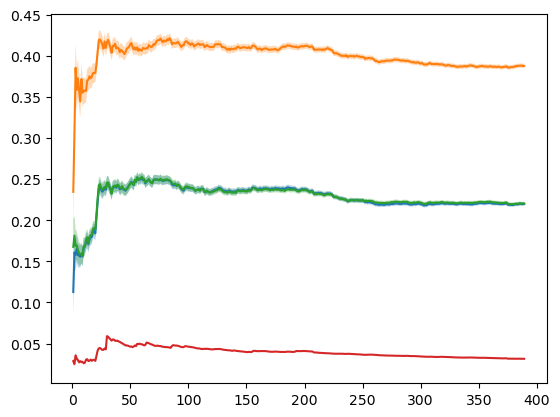

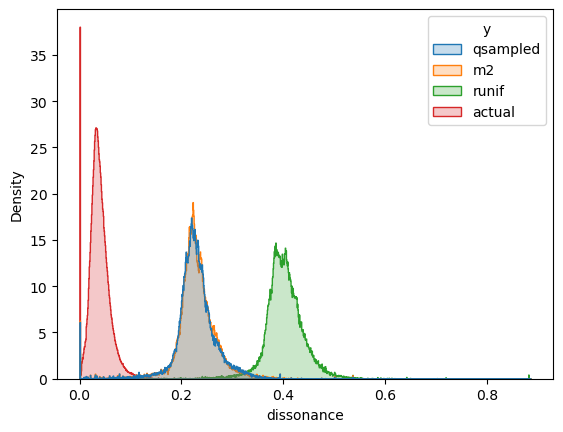

In [13]:
basepath = f"disson_new/global/core/disson_global_qmra_missing_0/"
qsteps = 71
nsamples = 100
num_questions = 390
groups = ["qsampled", "m2", "runif", "actual", "resampled"]

empty_string = np.full(len(model.feature_names), "", dtype="<U21")

for i in tqdm(range(1)):
    diss = pd.read_pickle(f"{basepath}random_order_disson_{i}.pkl")

    model = load_qnet(
        f"{basepath}random_order_full_model_{i}.joblib.gz",
        gz=True,
    )

    order = pd.read_csv(f"{basepath}random_order_{i}.csv", index_col=0)["0"]

    resampled = np.array(
        [qsample(empty_string, model, qsteps) for _ in tqdm(range(nsamples))]
    )

    resampled_df = pd.DataFrame(resampled).replace("", np.nan)
    resampled_na = resampled_df.isnull().sum(axis=1)
    resampled_nonna = (1 - resampled_na / len(model.feature_names)).mean()

    resampled_diss = _all_actual_samples_dissonance(
        resampled, [model], _diss_linear, order, 390
    )

    rsdffg = pd.concat(
        [
            pd.DataFrame(
                _dissonance_data_at_question(resampled_diss[1], questions_asked)
            ).assign(y="resampled", questions=str(questions_asked))
            for questions_asked in range(1, num_questions)
        ]
    )

    rsdffgm = (
        rsdffg.melt(id_vars=["y", "questions"])
        .query("~value.isna()")
        .assign(
            questions=lambda x: x["questions"].astype(int),
            variable=lambda x: x["variable"].astype(int),
        )
    )

    rsdd = pd.concat(
        [
            rsdffg.drop(["y", "questions"], axis="columns").mean(axis=1),
            rsdffg["y"],
            rsdffg["questions"],
        ],
        axis=1,
    ).set_axis(["dissonance", "y", "questions"], axis="columns")

    _process_csvs(
        basepath,
        390,
        get_csvs=True,
        csv_names=["dffg_resampled", "dffgm_resampled", "dd_resampled"],
        extradffg=rsdffg,
        extradffgm=rsdffgm,
        extradd=rsdd,
    )

    _plot_diss_dist(
        dffgm=pd.read_csv(f"{basepath}dffgm_resampled.csv"),
        dd=pd.read_csv(f"{basepath}dd_resampled.csv"),
        num_questions=390,
        outfile="data/dissonance_comparison/diss_comp_global_core_linear_rand_order_with_resampled_melt.csv",
        outfig=basepath,
        groups=["qsampled", "runif", "m2", "actual", "resampled"],
    )

In [17]:
d = pd.read_csv(f"{basepath}dffgm_resampled.csv")

In [20]:
d.query("y=='resampled'")

,y,questions,variable,value
30342000,resampled,1,0,0.0
30342001,resampled,1,0,0.0
30342002,resampled,1,0,0.0
30342003,resampled,1,0,0.0
30342004,resampled,1,0,0.0
...,...,...,...,...
45512995,resampled,389,388,0.0
45512996,resampled,389,388,0.0
45512997,resampled,389,388,0.0
45512998,resampled,389,388,0.0


  0%|          | 0/389 [00:00<?, ?it/s]

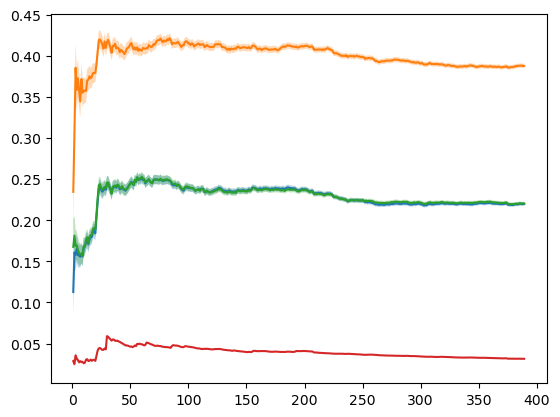

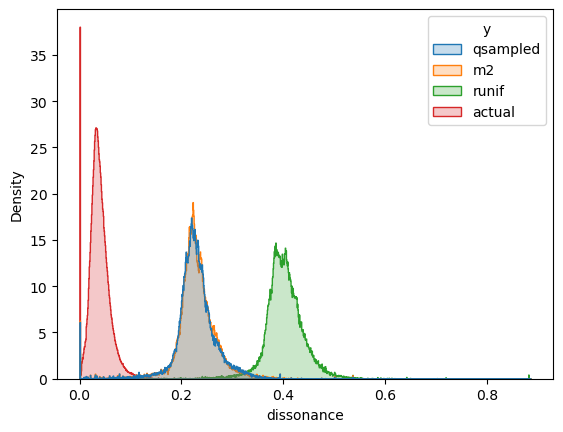

In [25]:
_plot_diss_dist(
    dffgm=pd.read_csv(f"{basepath}dffgm.csv"),
    dd=pd.read_csv(f"{basepath}dd.csv"),
    num_questions=390,
    outfile="data/dissonance_comparison/diss_comp_global_core_linear_rand_order_with_melt.csv",
    outfig=basepath,
    groups=["qsampled", "runif", "m2", "actual"],
)

# Global


## Core

In [26]:
dffgm = pd.read_csv(f"{basepath}dffgm.csv")
dd = pd.read_csv(f"{basepath}dd.csv")

In [27]:
empty_string = np.full(len(model.feature_names), "", dtype="<U21")

model = load_qnet(
    f"{basepath}random_order_full_model_{i}.joblib.gz",
    gz=True,
)

order = pd.read_csv(f"{basepath}random_order_{i}.csv", index_col=0)["0"]


resampled = np.array(
    [qsample(empty_string, model, qsteps) for _ in tqdm(range(nsamples))]
)

resampled_df = pd.DataFrame(resampled).replace("", np.nan)
resampled_na = resampled_df.isnull().sum(axis=1)
resampled_nonna = (1 - resampled_na / len(model.feature_names)).mean()


resampled_diss = _all_actual_samples_dissonance(
    resampled, [model], _diss_linear, order, 390
)

rsdffg = pd.concat(
    [
        pd.DataFrame(
            _dissonance_data_at_question(resampled_diss[1], questions_asked)
        ).assign(y="resampled", questions=str(questions_asked))
        for questions_asked in range(1, num_questions)
    ]
)

rsdffgm = (
    rsdffg.melt(id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

rsdd = pd.concat(
    [
        rsdffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        rsdffg["y"],
        rsdffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [32]:
new_dffgm = pd.concat([dffgm, rsdffgm])
new_dffgm

,y,questions,variable,value
0,qsampled,1,0,0.0
1,qsampled,1,0,0.0
2,qsampled,1,0,0.0
3,qsampled,1,0,0.0
4,qsampled,1,0,0.0
...,...,...,...,...
15132095,resampled,389,388,0.0
15132096,resampled,389,388,0.0
15132097,resampled,389,388,0.0
15132098,resampled,389,388,0.0


In [36]:
new_dd = pd.concat([dd, rsdd])
new_dd

,dissonance,y,questions
0,0.000000,qsampled,1
1,0.000000,qsampled,1
2,0.000000,qsampled,1
3,0.000000,qsampled,1
4,0.000000,qsampled,1
...,...,...,...
95,0.028736,resampled,389
96,0.021181,resampled,389
97,0.031506,resampled,389
98,0.039150,resampled,389


  0%|          | 0/389 [00:00<?, ?it/s]

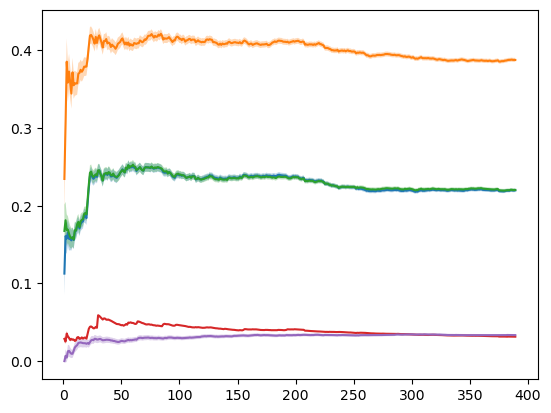

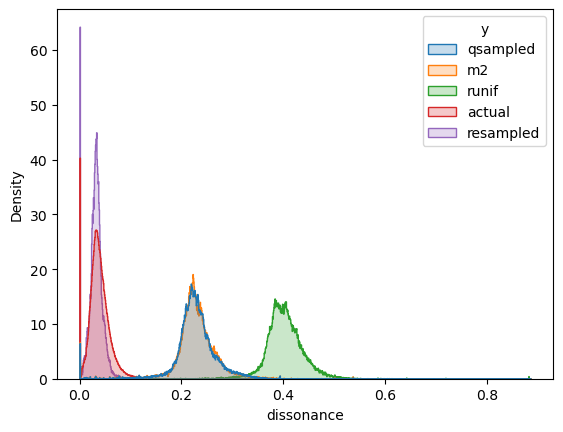

In [38]:
_plot_diss_dist(
    dffgm=new_dffgm,
    dd=new_dd,
    num_questions=390,
    outfile="data/dissonance_comparison/diss_comp_global_core_linear_rand_order_with_resampled_melt.csv",
    outfig=basepath,
    groups=["qsampled", "runif", "m2", "actual", "resampled"],
)

## Dx

In [41]:
order = pd.read_csv(
    "disson_new/global/dx/disson_global_qmra_missing_0/random_order_0.csv", index_col=0
)["0"]

In [42]:
qsteps = 71
nsamples = 100

resampled = np.array(
    [qsample(empty_string, model, qsteps) for _ in tqdm(range(nsamples))]
)

resampled_df = pd.DataFrame(resampled).replace("", np.nan)
resampled_na = resampled_df.isnull().sum(axis=1)
resampled_nonna = (1 - resampled_na / len(model.feature_names)).mean()
resampled_nonna

  0%|          | 0/100 [00:00<?, ?it/s]

0.16733333333333322

In [60]:
basepath = f"disson_new/global/dx/disson_global_qmra_missing_0/"
qsteps = 71
nsamples = 100
num_questions = 345
groups = ["qsampled", "m2", "runif", "actual", "resampled"]

empty_string = np.full(len(model.feature_names), "", dtype="<U21")

In [61]:
dffgm = pd.read_csv(f"{basepath}dffgm.csv")
dd = pd.read_csv(f"{basepath}dd.csv")

In [62]:
empty_string = np.full(len(model.feature_names), "", dtype="<U21")

model = load_qnet(
    f"{basepath}random_order_full_model_{i}.joblib.gz",
    gz=True,
)

order = pd.read_csv(f"{basepath}random_order_{i}.csv", index_col=0)["0"]


resampled = np.array(
    [qsample(empty_string, model, qsteps) for _ in tqdm(range(nsamples))]
)

resampled_df = pd.DataFrame(resampled).replace("", np.nan)
resampled_na = resampled_df.isnull().sum(axis=1)
resampled_nonna = (1 - resampled_na / len(model.feature_names)).mean()


resampled_diss = _all_actual_samples_dissonance(
    resampled, [model], _diss_linear, order, 346
)

rsdffg = pd.concat(
    [
        pd.DataFrame(
            _dissonance_data_at_question(resampled_diss[1], questions_asked)
        ).assign(y="resampled", questions=str(questions_asked))
        for questions_asked in range(1, num_questions)
    ]
)

rsdffgm = (
    rsdffg.melt(id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

rsdd = pd.concat(
    [
        rsdffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        rsdffg["y"],
        rsdffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [63]:
new_dffgm = pd.concat([dffgm, rsdffgm])
new_dd = pd.concat([dd, rsdd])

In [64]:
new_dd

,dissonance,y,questions
0,0.337349,qsampled,1
1,0.000000,qsampled,1
2,0.156627,qsampled,1
3,0.000000,qsampled,1
4,0.108434,qsampled,1
...,...,...,...
95,0.041202,resampled,344
96,0.048233,resampled,344
97,0.028941,resampled,344
98,0.031855,resampled,344


  0%|          | 0/344 [00:00<?, ?it/s]

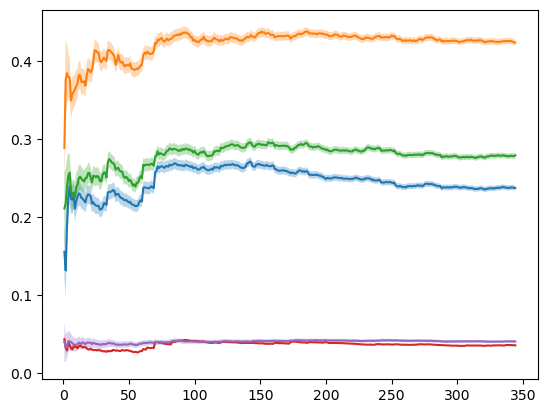

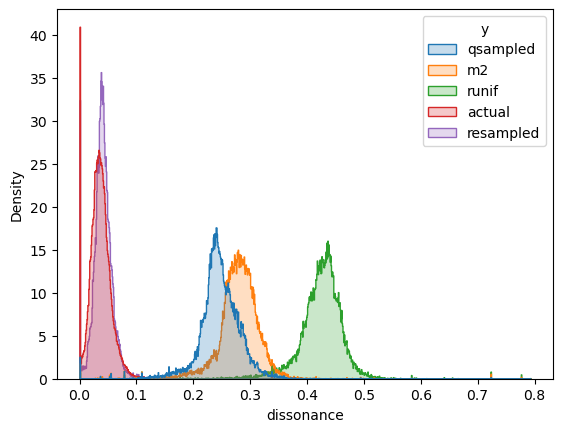

In [65]:
_plot_diss_dist(
    dffgm=new_dffgm,
    dd=new_dd,
    num_questions=345,
    outfile="data/dissonance_comparison/diss_comp_global_dx_linear_rand_order_with_resampled_melt.csv",
    outfig=basepath,
    groups=["qsampled", "runif", "m2", "actual", "resampled"],
)

# Bond court

In [ ]:
basepath = f"disson_new/bondcourt/core/disson_bond_qmra_missing_0/"

qsteps = 19
nsamples = 100
num_questions = 43

rdffg, rdffgm, rdd, rdiss = _resample_null(
    nsamples,
    qsteps,
    num_questions,
    basepath,
    pd.read_csv(f"{basepath}dffg.csv"),
    pd.read_csv(f"{basepath}dffgm.csv"),
    pd.read_csv(f"{basepath}dd.csv"),
)

In [65]:
pkl = pd.read_pickle(f"disson_new/bondcourt/core/disson_bond_qmra_missing_0/random_order_disson_0.pkl")

In [71]:
rdiss[1]

[[array([0.70444763]),
  array([0.        , 0.70444763]),
  array([0.        , 0.70444763, 0.        ]),
  array([0.        , 0.        , 0.70444763, 0.        ]),
  array([0.        , 0.        , 0.70444763, 0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.70444763, 0.        ,
         0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.70444763,
         0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.70444763, 0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.70444763, 0.        , 0.        ]),
  array([0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.70444763, 0.        , 0.        ]),
  array([0.        , 0.        , 0.88983051, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.70444763, 0.        ,
         0.        ]),
  array([0.        , 0. 

In [68]:
pkl["resampled"] = rdiss.fillna(0)

AttributeError: 'list' object has no attribute 'fillna'

In [58]:
rdffg.query("y == 'resampled' & questions==2")

,0,y,questions,1,2,3,4,5,6,7,...,32,33,34,35,36,37,38,39,40,41


In [31]:
pd.read_csv("disson_new/bondcourt/core/disson_bond_qmra_missing_0/dffgm.csv")

,y,questions,variable,value
0,qsampled,1,0,0.000000
1,qsampled,1,0,0.832432
2,qsampled,1,0,0.000000
3,qsampled,1,0,0.000000
4,qsampled,1,0,0.832432
...,...,...,...,...
13996495,actual,42,41,0.000000
13996496,actual,42,41,0.000000
13996497,actual,42,41,0.000000
13996498,actual,42,41,0.000000


  0%|          | 0/42 [00:00<?, ?it/s]

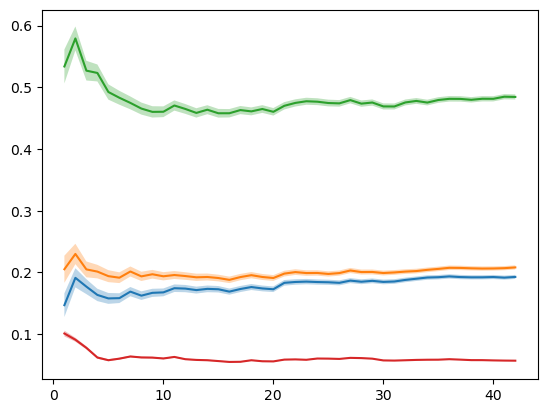

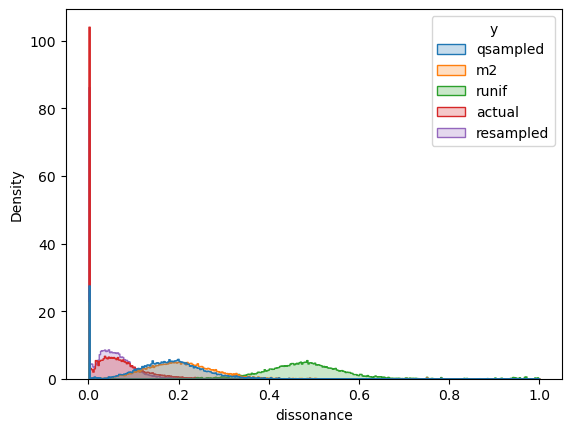

In [32]:
_plot_diss_dist(
    dffgm=rdffgm,
    dd=rdd,
    num_questions=43,
    outfile="data/dissonance_comparison/diss_comp_bondcourt_core_linear_rand_order_missing_0_melt_new_m2xx.csv",
    outfig="disson_new/bondcourt/core/disson_bond_qmra_missing_0/"
)

In [73]:
_diss_dataset(pkl, 10, groups=groups)

0     resampled
1     resampled
2     resampled
3     resampled
4     resampled
        ...    
95        runif
96        runif
97        runif
98        runif
99        runif
Name: y, Length: 200, dtype: object

In [88]:
diss = [
    pd.read_pickle(d)
    for d in glob.glob("disson_new/bondcourt/core/disson_bond_qmra_missing_0/random_order_disson*.pkl")
]

diss = [pkl]


groups = ["resampled", "runif"]
output_path = "data/classification/new/bpndcourt/runif/xx"
name = f"rf_{groups[1]}_runif_random_order"

retrains = 3
n_trials = 50
question_iter = range(1, 43, 5)

_classification(diss, groups, output_path, name, retrains, n_trials, question_iter,)

Dissonance files:   0%|          | 0/1 [00:00<?, ?it/s]

Training cycles this file:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-10-31 22:06:47,949] A new study created in memory with name: no-name-9dac8152-d1c1-4f1e-a615-e56ef270aa20
[I 2023-10-31 22:06:48,229] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 201, 'max_depth': 13, 'min_samples_split': 13}. Best is trial 0 with value: 1.0.
[I 2023-10-31 22:06:48,452] Trial 1 finished with value: 1.0 and parameters: {'n_estimators': 158, 'max_depth': 15, 'min_samples_split': 11}. Best is trial 0 with value: 1.0.
[I 2023-10-31 22:06:48,619] Trial 2 finished with value: 1.0 and parameters: {'n_estimators': 120, 'max_depth': 13, 'min_samples_split': 14}. Best is trial 0 with value: 1.0.
[I 2023-10-31 22:06:48,947] Trial 3 finished with value: 1.0 and parameters: {'n_estimators': 219, 'max_depth': 5, 'min_samples_split': 27}. Best is trial 0 with value: 1.0.
[I 2023-10-31 22:06:49,147] Trial 4 finished with value: 1.0 and parameters: {'n_estimators': 142, 'max_depth': 15, 'min_samples_split': 21}. Best is trial 0 with value: 1.0.
[I 2023-10-3

OSError: Cannot save file into a non-existent directory: 'data/classification/new/bpndcourt/runif'

In [78]:
basepath = f"disson_new/bondcourt/core/disson_bond_qmra_missing_0/"

actual_data = pd.read_csv("data/bondcourt/CCHHS_SUD_details.csv")

model = load_qnet(
    f"{basepath}random_order_full_model_{i}.joblib.gz",
    gz=True,
)

empty_string = np.full(len(model.feature_names), "", dtype="<U21")

order = pd.read_csv(f"{basepath}random_order_{i}.csv", index_col=0)["0"]

actual_model = actual_data[model.feature_names].isnull().sum(axis=1)
avg_non_null = (1 - actual_model / len(model.feature_names)).mean()

avg_non_null

0.36579047619047617

In [79]:
qsteps = 19
nsamples = 100

resampled = np.array(
    [qsample(empty_string, model, qsteps) for _ in tqdm(range(nsamples))]
)

resampled_df = pd.DataFrame(resampled).replace("", np.nan)
resampled_na = resampled_df.isnull().sum(axis=1)
resampled_nonna = (1 - resampled_na / len(model.feature_names)).mean()

resampled_nonna

  0%|          | 0/100 [00:00<?, ?it/s]

0.3673809523809524

In [85]:
qsteps = qsteps
nsamples = 100
num_questions = len(model.feature_names)
groups = ["qsampled", "m2", "runif", "actual", "resampled"]

dffgm = pd.read_csv(f"{basepath}dffgm.csv")
dd = pd.read_csv(f"{basepath}dd.csv")

In [88]:
new_dffgm, new_dd = _resample_null(model, nsamples, qsteps, num_questions)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
resampled = np.array(
    [qsample(empty_string, model, qsteps) for _ in tqdm(range(nsamples))]
)

resampled_df = pd.DataFrame(resampled).replace("", np.nan)
resampled_na = resampled_df.isnull().sum(axis=1)
resampled_nonna = (1 - resampled_na / len(model.feature_names)).mean()

resampled_diss = _all_actual_samples_dissonance(
    resampled, [model], _diss_linear, order, 346
)

rsdffg = pd.concat(
    [
        pd.DataFrame(
            _dissonance_data_at_question(resampled_diss[1], questions_asked)
        ).assign(y="resampled", questions=str(questions_asked))
        for questions_asked in range(1, num_questions)
    ]
)

rsdffgm = (
    rsdffg.melt(id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

rsdd = pd.concat(
    [
        rsdffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        rsdffg["y"],
        rsdffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

new_dffgm = pd.concat([dffgm, rsdffgm])
new_dd = pd.concat([dd, rsdd])

In [ ]:
_plot_diss_dist(
    dffgm=new_dffgm,
    dd=new_dd,
    num_questions=num_questions,
    outfile="data/dissonance_comparison/diss_comp_bondcourt_dx_linear_rand_order_with_resampled_melt.csv",
    outfig=basepath,
    groups=["qsampled", "runif", "m2", "actual", "resampled"],
)

# PTSD

## Dx

In [90]:
basepath = f"disson_new/ptsd/dx/disson_ptsd_qmra/"

actual_data = pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv")

model = load_qnet(
    f"{basepath}random_order_full_model_{0}.joblib.gz",
    gz=True,
)

empty_string = np.full(len(model.feature_names), "", dtype="<U21")

order = pd.read_csv(f"{basepath}random_order_{0}.csv", index_col=0)["0"]

actual_model = actual_data[model.feature_names].isnull().sum(axis=1)
avg_non_null = (1 - actual_model / len(model.feature_names)).mean()

avg_non_null

1.0

In [94]:
qsteps = 1500
nsamples = 100

resampled = np.array(
    [qsample(empty_string, model, qsteps) for _ in tqdm(range(nsamples))]
)

resampled_df = pd.DataFrame(resampled).replace("", np.nan)
resampled_na = resampled_df.isnull().sum(axis=1)
resampled_nonna = (1 - resampled_na / len(model.feature_names)).mean()

resampled_nonna

  0%|          | 0/100 [00:00<?, ?it/s]

0.9990521327014218

In [95]:
qsteps = qsteps
nsamples = 100
num_questions = len(model.feature_names)
groups = ["qsampled", "m2", "runif", "actual", "resampled"]

dffgm = pd.read_csv(f"{basepath}dffgm.csv")
dd = pd.read_csv(f"{basepath}dd.csv")

In [96]:
new_dffgm, new_dd = _resample_null(model, nsamples, qsteps, num_questions)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

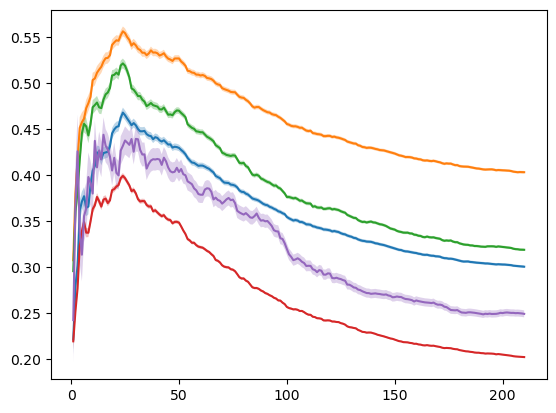

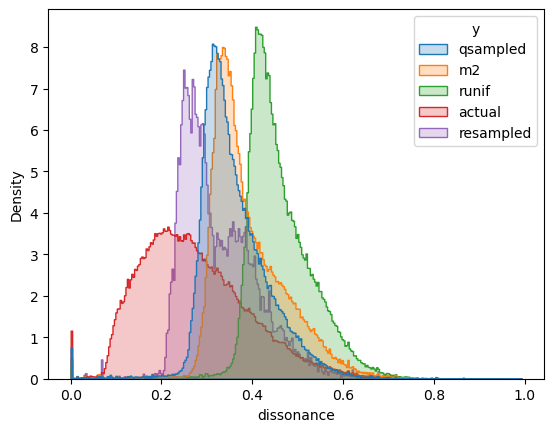

: 

In [97]:
_plot_diss_dist(
    dffgm=new_dffgm,
    dd=new_dd,
    num_questions=num_questions,
    outfile="data/dissonance_comparison/diss_comp_ptsd_dx_linear_rand_order_with_resampled_melt.csv",
    outfig=basepath,
    groups=["qsampled", "runif", "m2", "actual", "resampled"],
)

## Core

In [5]:
basepath = f"disson_new/ptsd/core/disson_ptsd_qmra/"

actual_data = pd.read_csv("data/ptsd/PTSD_cognet_test_processed.csv")

model = load_qnet(
    f"{basepath}random_order_full_model_{0}.joblib.gz",
    gz=True,
)

empty_string = np.full(len(model.feature_names), "", dtype="<U21")

order = pd.read_csv(f"{basepath}random_order_{0}.csv", index_col=0)["0"]

actual_model = actual_data[model.feature_names].isnull().sum(axis=1)
avg_non_null = (1 - actual_model / len(model.feature_names)).mean()

avg_non_null

1.0

In [6]:
qsteps = 1500
nsamples = 100

resampled = np.array(
    [qsample(empty_string, model, qsteps) for _ in tqdm(range(nsamples))]
)

resampled_df = pd.DataFrame(resampled).replace("", np.nan)
resampled_na = resampled_df.isnull().sum(axis=1)
resampled_nonna = (1 - resampled_na / len(model.feature_names)).mean()

resampled_nonna

  0%|          | 0/100 [00:00<?, ?it/s]

0.9993364928909952

In [7]:
qsteps = qsteps
nsamples = 100
num_questions = len(model.feature_names)
groups = ["qsampled", "m2", "runif", "actual", "resampled"]

dffgm = pd.read_csv(f"{basepath}dffgm.csv")
dd = pd.read_csv(f"{basepath}dd.csv")

In [11]:
new_dffgm, new_dd = _resample_null(model, nsamples, qsteps, num_questions)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/210 [00:00<?, ?it/s]

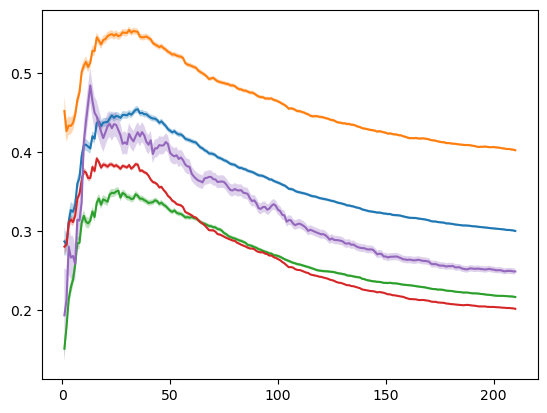

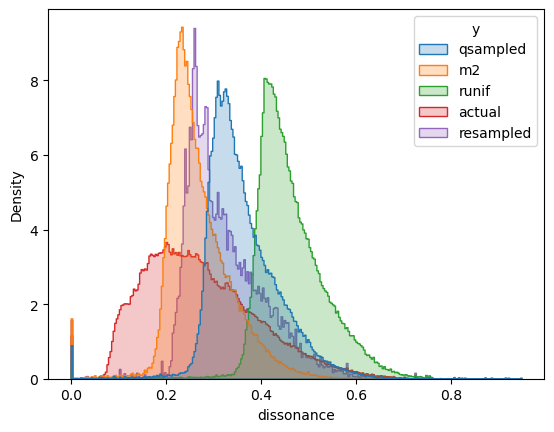

In [12]:
_plot_diss_dist(
    dffgm=new_dffgm,
    dd=new_dd,
    num_questions=num_questions,
    outfile="data/dissonance_comparison/diss_comp_ptsd_core_linear_rand_order_with_resampled_melt.csv",
    outfig=basepath,
    groups=["qsampled", "runif", "m2", "actual", "resampled"],
)

In [27]:
basepath = f"disson_new/ptsd/core/disson_ptsd_qmra/"

qsteps = 1500
nsamples = 100
num_questions = 212

rdffg, rdffgm, rdd = _resample_null(
    nsamples,
    qsteps,
    num_questions,
    basepath,
    pd.read_csv(f"{basepath}dffg.csv"),
    pd.read_csv(f"{basepath}dffgm.csv"),
    pd.read_csv(f"{basepath}dd.csv"),
)

0it [00:00, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

# other version

In [ ]:
resampled_diss = _all_actual_samples_dissonance(
    resampled, [model], _diss_linear, range(390), 390
)

In [83]:
# resampled_diss[dissonances(not samples)][subject][model][questions]
resampled = pd.DataFrame(_dissonance_data_at_question(resampled_diss[1], 10)).assign(
    y="resampled"
)

In [ ]:
pd.concat()

In [44]:
actual_diss = pd.read_csv(
    "disson_global/core/disson_global_core_with_actual_ff/random_order_dissonance_matrix_1.csv",
    index_col=0,
)

In [47]:
resampled_final_diss = pd.DataFrame(
    np.array([resampled_diss[1][subj][0][-1] for subj in range(100)])
).set_axis(actual_diss.columns, axis="columns")

In [91]:
questions = 10
resampled = pd.DataFrame(
    _dissonance_data_at_question(resampled_diss[1], questions)
).assign(y="resampled")

pd.concat(
    [
        _diss_dataset(
            disson, questions, groups=["qsampled", "m2", "runif", "actual"]
        ).iloc[:, np.r_[:questions, -1]],
        resampled,
    ]
)

,0,1,2,3,4,5,6,7,8,9,y
0,0.000000,0.000000,0.554217,0.635294,0.0,0.0,0.095745,0.000000,0.333333,0.9,qsampled
1,0.726619,0.000000,0.084337,0.117647,0.0,0.0,0.531915,0.692308,0.444444,0.3,qsampled
2,0.000000,0.000000,0.554217,0.000000,0.0,0.0,0.000000,0.153846,0.358025,0.3,qsampled
3,0.726619,0.000000,0.000000,0.000000,0.0,0.0,0.531915,0.153846,0.333333,0.3,qsampled
4,0.726619,0.794118,0.554217,0.117647,0.0,0.0,0.276596,0.000000,0.753086,0.9,qsampled
...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.867257,0.000000,0.0,resampled
96,0.571429,0.111111,0.000000,0.740053,0.0,0.0,0.478632,0.000000,0.000000,0.0,resampled
97,0.000000,0.000000,0.000000,0.740053,0.0,0.0,0.000000,0.000000,0.000000,0.0,resampled
98,0.571429,0.111111,0.000000,0.740053,0.0,0.0,0.478632,0.000000,0.726619,0.0,resampled


In [92]:
for i in tqdm(range(1)):
    disson = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )
    diss = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )

    samps = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_samples_{i}.pkl"
    )

    model = load_qnet(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_full_model_{i}.joblib.gz",
        gz=True,
    )

    d = samps["qsampled"]
    resampled = np.array([qsample(s, model, 1000) for s in tqdm(d)])
    resampled_diss = _all_actual_samples_dissonance(
        resampled, [model], _diss_linear, range(390), 390
    )

    resampled_df = pd.DataFrame(
        _dissonance_data_at_question(resampled_diss[1], questions)
    ).assign(y="resampled")

    [
        pd.concat(
            [
                _diss_dataset(
                    disson, questions, groups=["qsampled", "m2", "runif", "actual"]
                ),
                resampled_df,
            ]
        ).to_csv(
            f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_random_order_disson_{i}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in tqdm(range(1, 390))
    ]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

In [93]:
dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, 390)
        for i in range(1)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

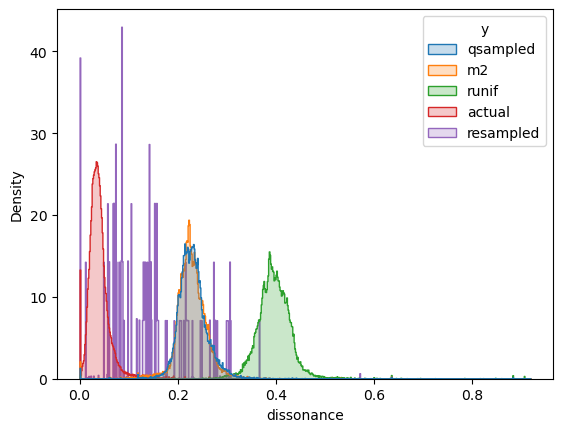

In [94]:
fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

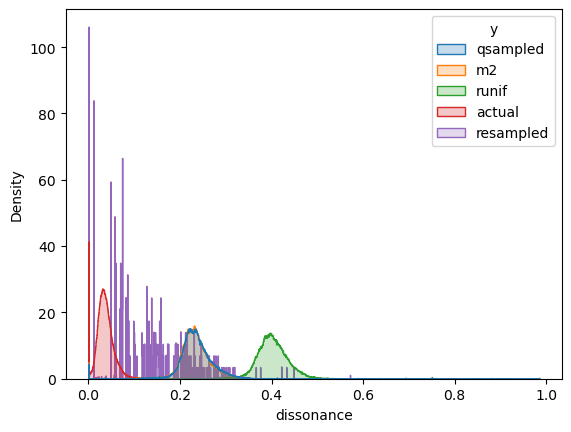

In [100]:
nquestions = 390
qsample_steps = 2500

for i in tqdm(range(4)):
    disson = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )
    diss = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )

    samps = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_samples_{i}.pkl"
    )

    model = load_qnet(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_full_model_{i}.joblib.gz",
        gz=True,
    )

    d = samps["qsampled"]
    resampled = np.array([qsample(s, model, qsample_steps) for s in tqdm(d)])
    resampled_diss = _all_actual_samples_dissonance(
        resampled, [model], _diss_linear, range(nquestions), nquestions
    )

    resampled_df = pd.DataFrame(
        _dissonance_data_at_question(resampled_diss[1], questions)
    ).assign(y="resampled")

    [
        pd.concat(
            [
                _diss_dataset(
                    disson, questions, groups=["qsampled", "m2", "runif", "actual"]
                ),
                resampled_df,
            ]
        ).to_csv(
            f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in tqdm(range(1, nquestions))
    ]

dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, nquestions)
        for i in range(4)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

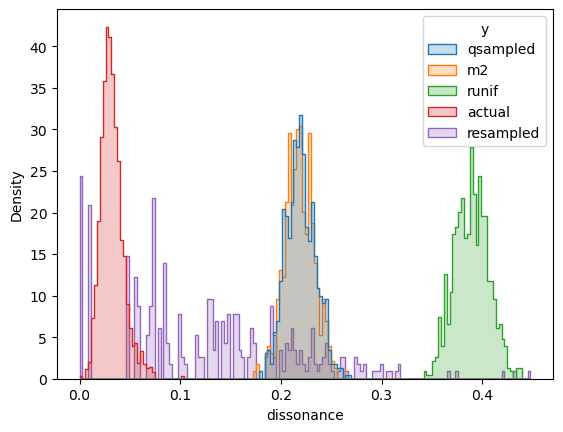

In [101]:
dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(nquestions - 2, nquestions)
        for i in range(4)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

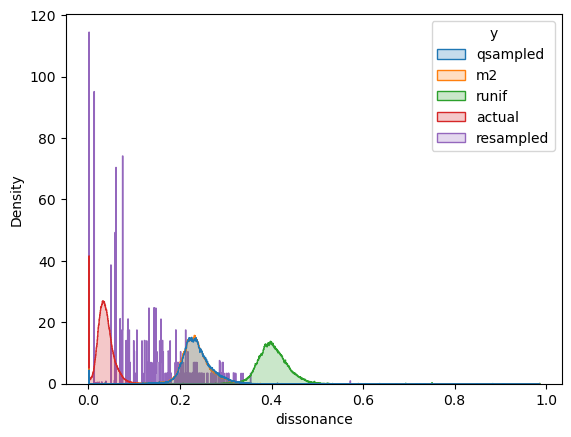

In [102]:
nquestions = 390
qsample_steps = 5000

for i in tqdm(range(4)):
    disson = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )
    diss = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )

    samps = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_samples_{i}.pkl"
    )

    model = load_qnet(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_full_model_{i}.joblib.gz",
        gz=True,
    )

    d = samps["qsampled"]
    resampled = np.array([qsample(s, model, qsample_steps) for s in tqdm(d)])
    resampled_diss = _all_actual_samples_dissonance(
        resampled, [model], _diss_linear, range(nquestions), nquestions
    )

    resampled_df = pd.DataFrame(
        _dissonance_data_at_question(resampled_diss[1], questions)
    ).assign(y="resampled")

    [
        pd.concat(
            [
                _diss_dataset(
                    disson, questions, groups=["qsampled", "m2", "runif", "actual"]
                ),
                resampled_df,
            ]
        ).to_csv(
            f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in tqdm(range(1, nquestions))
    ]

dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, nquestions)
        for i in range(4)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

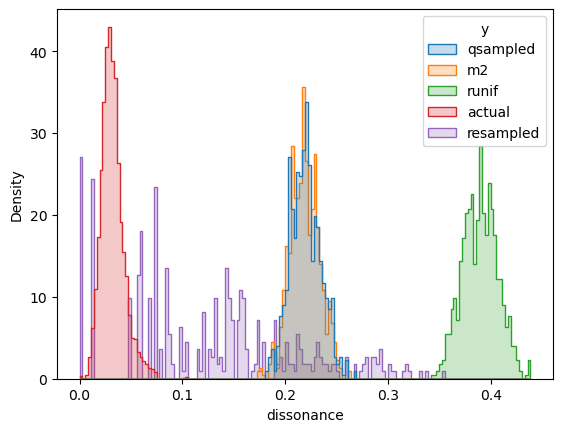

: 

In [103]:
dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_resampled_{qsample_steps}_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(nquestions - 2, nquestions)
        for i in range(4)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

In [ ]:
[
    _diss_dataset(
        disson, questions, groups=["qsampled", "m2", "runif", "actual"]
    ).to_csv(
        f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_random_order_disson_{i}-questions_asked_{questions}.csv",
        index=False,
    )
    for questions in range(1, 390)
]

In [63]:
groups = ["actual"]

questions_asked = 390
data = _diss_dataset(diss, questions_asked, groups=groups)

datad = data.iloc[:, np.r_[:questions_asked]].set_axis(
    actual_diss.columns, axis="columns"
)

<AxesSubplot:xlabel='value', ylabel='Density'>

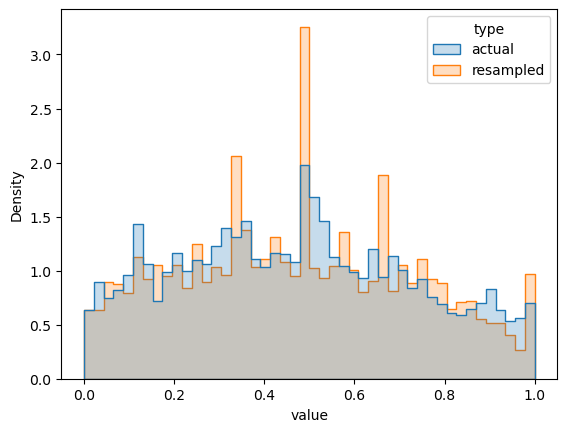

In [69]:
comb = pd.melt(
    pd.concat(
        [
            datad.assign(type="actual"),
            resampled_final_diss.assign(type="resampled"),
        ]
    ),
    id_vars="type",
)

sns.histplot(
    comb.query("value > 0"),
    x="value",
    element="step",
    stat="density",
    hue="type",
    common_norm=False,
    kde=False,
)

In [71]:
for i in tqdm(range(4)):
    disson = pd.read_pickle(
        f"disson_global/core/disson_global_core_with_actual_ff/random_order_disson_{i}.pkl"
    )

    [
        _diss_dataset(
            disson, questions, groups=["qsampled", "m2", "runif", "actual"]
        ).to_csv(
            f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_random_order_disson_{i}-questions_asked_{questions}.csv",
            index=False,
        )
        for questions in range(1, 390)
    ]

  0%|          | 0/4 [00:00<?, ?it/s]

In [72]:
dffg = pd.concat(
    [
        pd.concat(
            [
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                ).iloc[:, np.r_[:questions_asked]],
                # .mean(axis=1, numeric_only=True),
                pd.read_csv(
                    f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/disson_global_core_with_actual_random_order_disson_{i}-questions_asked_{questions_asked}.csv"
                )["y"],
            ],
            axis=1,
        )
        # .groupby("y", as_index=False)
        # .mean()
        .assign(questions=str(questions_asked))
        for questions_asked in range(1, 345)
        for i in range(4)
    ]
)

dffgm = (
    pd.melt(dffg, id_vars=["y", "questions"])
    .query("~value.isna()")
    .assign(
        questions=lambda x: x["questions"].astype(int),
        variable=lambda x: x["variable"].astype(int),
    )
)

dd = pd.concat(
    [
        dffg.drop(["y", "questions"], axis="columns").mean(axis=1),
        dffg["y"],
        dffg["questions"],
    ],
    axis=1,
).set_axis(["dissonance", "y", "questions"], axis="columns")

<AxesSubplot:xlabel='dissonance', ylabel='Density'>

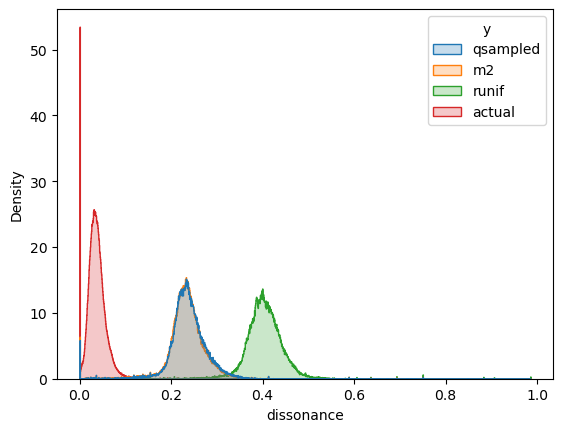

In [73]:
fig, ax = plt.subplots()
sns.histplot(
    dd.reset_index(),
    x="dissonance",
    hue="y",
    ax=ax,
    element="step",
    stat="density",
    common_norm=False,
    kde=False,
)

In [75]:
dd.query("y=='actual'")

,dissonance,y,questions
300,0.000000,actual,1
301,0.000000,actual,1
302,0.000000,actual,1
303,0.117647,actual,1
304,0.117647,actual,1
...,...,...,...
1531,0.045066,actual,344
1532,0.033017,actual,344
1533,0.036635,actual,344
1534,0.035962,actual,344


In [70]:
from pathlib import Path

for i in range(4):
    Path(f"disson_global/core/disson_global_core_with_actual_ff/csv/{i}/").mkdir(
        parents=True, exist_ok=True
    )